In [1]:
cd /home

/home


In [8]:
import tensorflow as tf
import pandas as pd 

import matplotlib.pyplot as plt

import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

%load_ext autoreload
%autoreload 2

from src.data.loaders import load_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## RECORDS

In [33]:
data = load_data('./data/records/atlas/fold_0/atlas_100/test/',
                    batch_size=32,
                    window_size=200,
                    sampling=True,
                    nsp_prob=.5,
                    test_mode=True)

[INFO] Sampling random windows


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


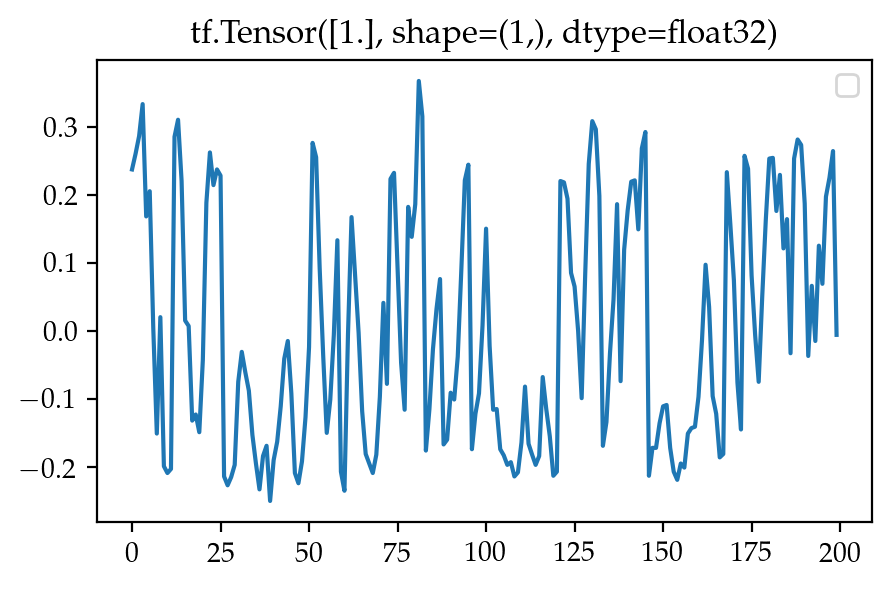

In [34]:
plt.figure(figsize=(5, 3), dpi=200)
for x, y in data.take(1):
    
    curr_x = x['magnitudes'][0, 1:, 0]
    curr_m = x['mask'][0]
    
    curr_x = tf.boolean_mask(curr_x, curr_m)
    
    plt.title(str(y['nsp_label'][0]))
    plt.plot(curr_x)
    plt.legend()
plt.show()

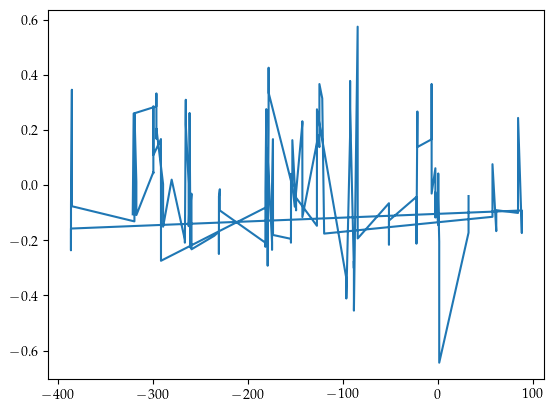

In [148]:
from src.data.nsp import get_segment_length, creat_mask_given_lenghts, \
                         concat_segments
for x, y in data.take(1):
    inp_size = tf.shape(x['original'])

    indices = tf.range(0, inp_size[0], dtype=tf.int32)
    indices = tf.random.shuffle(indices)  
        
    x_replace = tf.gather(x['original'], indices)
    m_replace = tf.gather(x['mask'], indices)
    
    length_0 = get_segment_length(x['mask'], inp_size[1], divide_factor=2) 
    length_1 = inp_size[1] - length_0
        
    mask_0 = creat_mask_given_lenghts(length_0, inp_size[1])
    mask_1 = creat_mask_given_lenghts(length_1, inp_size[1])
    
    # === Input values ====
    nsp_input = concat_segments(x['original'], x_replace, mask_0, mask_1)
    
    plt.plot(nsp_input[0][:, 0], nsp_input[0][:, 1])
#     plt.plot(x['original'][0][:, 0], x['original'][0][:, 1])
    

In [99]:
t = [[0, 1, 2, 3, 4], 
     [5, 6, 7, 8, 9], 
     [5, 6, 7, 8, 9]]

tf.roll(t, shift=[3, -1], axis=[1, 1])


<tf.Tensor: shape=(3, 5), dtype=int32, numpy=
array([[3, 4, 0, 1, 2],
       [8, 9, 5, 6, 7],
       [8, 9, 5, 6, 7]], dtype=int32)>

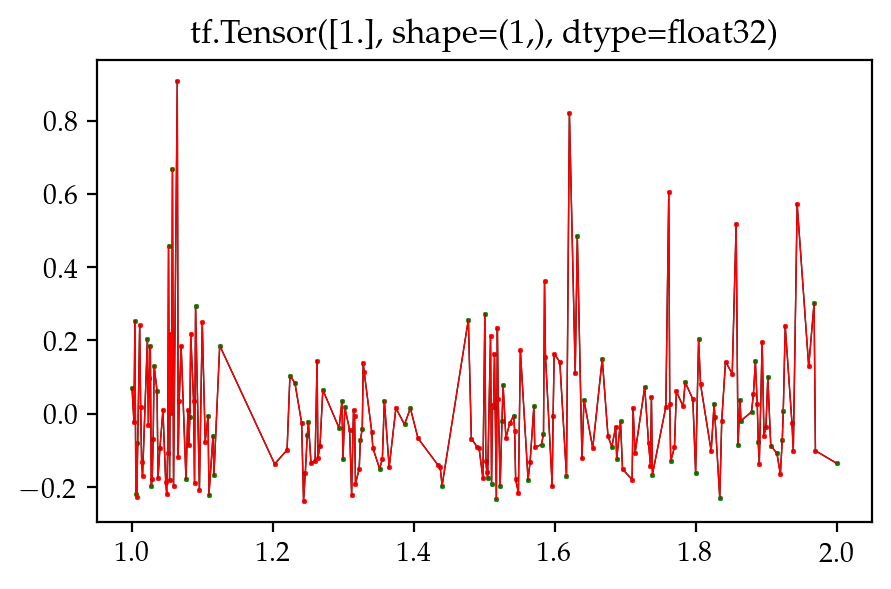

In [23]:
import numpy as np
plt.figure(figsize=(5, 3), dpi=200)
for x, y in data.take(1):
    
    N =1
    
    original   = x['original'][N]
    mask       = x['mask'][N]
    magnitudes = x['magnitudes'][N, 1:, 0]
    att_mask   = x['att_mask'][N, 1:, 0]
    times      = x['times'][N, 1:, 0]
    
    visible = tf.boolean_mask(magnitudes, 1.-att_mask)    
    times_visible = tf.boolean_mask(times, 1.-att_mask) 
    
    target = y['magnitudes'][N, :, 0]
    target = tf.boolean_mask(target, y['probed_mask'][N, :, 0])
    
    times_target = tf.boolean_mask(times, y['probed_mask'][N, :, 0]) 
    
    plt.scatter(times_visible, visible, marker='s', s=1, color='r')
    plt.scatter(times_target, target, marker='s', s=1, color='g')
    
    original = tf.boolean_mask(original, mask)
    times = tf.boolean_mask(times, mask)
    
    inputs = tf.boolean_mask(magnitudes, mask)

    plt.plot(times, original[:, 1], linestyle='-', linewidth=.5, color='k')
    plt.plot(times, inputs, linestyle='-', linewidth=.5, color='r')
    
    plt.title(str(y['nsp_label'][N]))